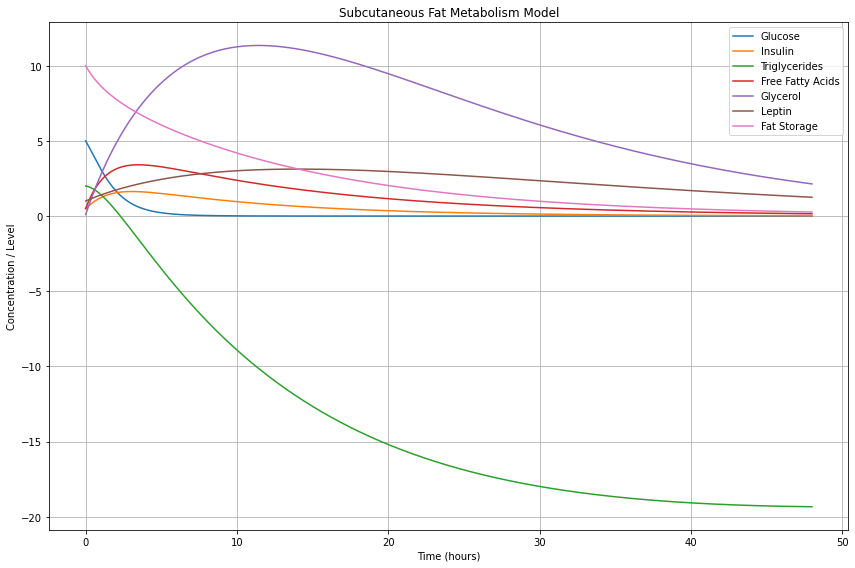

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

#Model an "IV infusion" and then we can go and change the feed, and get the code running for that first. When we run the model, 
#we shouldn't see much happening in 48 hours, so let's look at around a year. Eventually scale up to 5 or 10 years
# Clarify what the feed looks like, where is it going??  
# Multiple meals - run the code for a period of time, add new food at different time periods, can model IF
# Input value is zero at that time point 
#Fix something in the triglycerides, it shouldn't be negative 



# Define the system of ODEs
def fat_metabolism(y, t, params):
    G, I, TG, FFA, Glycerol, Leptin, Fat_Storage = y
    k_glucose_uptake, k_insulin_secretion, k_TG_input, k_lipogenesis, k_DNL, k_lipolysis, k_leptin_prod, k_FFA_use, k_glycerol_use = params

    # Glucose uptake by adipose (insulin-dependent)
    glucose_uptake = k_glucose_uptake * G * I

    # Insulin production (depends on glucose levels)
    insulin_secretion = k_insulin_secretion * G

    # Dietary TG input (assumed constant or meal-pulsed externally)
    TG_input = k_TG_input

    # Lipogenesis (storage of FFA into fat)
    lipogenesis = k_lipogenesis * FFA

    # De novo lipogenesis (from glucose to fat)
    DNL = k_DNL * G

    # Lipolysis (breakdown of stored fat)
    lipolysis = k_lipolysis * Fat_Storage

    # Leptin production proportional to fat storage
    leptin_prod = k_leptin_prod * Fat_Storage

    # FFA use by peripheral tissues
    FFA_use = k_FFA_use * FFA

    # Glycerol use by liver
    glycerol_use = k_glycerol_use * Glycerol

    # ODEs
    dG_dt = -glucose_uptake - DNL
    dI_dt = insulin_secretion - 0.1 * I
    dTG_dt = TG_input - lipogenesis
    dFFA_dt = lipolysis - lipogenesis - FFA_use
    dGlycerol_dt = lipolysis - glycerol_use
    dLeptin_dt = leptin_prod - 0.05 * Leptin
    dFat_Storage_dt = lipogenesis + DNL - lipolysis

    return [dG_dt, dI_dt, dTG_dt, dFFA_dt, dGlycerol_dt, dLeptin_dt, dFat_Storage_dt]

# Initial concentrations: [Glucose, Insulin, Triglycerides, FFA, Glycerol, Leptin, Fat_Storage]
y0 = [5.0, 0.5, 2.0, 0.5, 0.1, 1.0, 10.0]

# Parameters: tunable constants
#  fed-but-balanced state — there's some energy available, some insulin, and some fat storage to draw from.
params = [
    0.3,  # k_glucose_uptake
    0.2,  # k_insulin_secretion
    0.05, # k_TG_input
    0.4,  # k_lipogenesis
    0.2,  # k_DNL
    0.3,  # k_lipolysis
    0.05, # k_leptin_prod
    0.2,  # k_FFA_use
    0.1   # k_glycerol_use
]

# Time points (e.g., 0 to 48 hours)
t = np.linspace(0, 48, 500)

# Solve ODEs
solution = odeint(fat_metabolism, y0, t, args=(params,))
G, I, TG, FFA, Glycerol, Leptin, Fat_Storage = solution.T

# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(t, G, label='Glucose')
plt.plot(t, I, label='Insulin')
plt.plot(t, TG, label='Triglycerides')
plt.plot(t, FFA, label='Free Fatty Acids')
plt.plot(t, Glycerol, label='Glycerol')
plt.plot(t, Leptin, label='Leptin')
plt.plot(t, Fat_Storage, label='Fat Storage')
plt.xlabel('Time (hours)')
plt.ylabel('Concentration / Level')
plt.title('Subcutaneous Fat Metabolism Model')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Attempted explanation

### Glucose Drops Quickly
Because insulin is present, so glucose uptake by fat cells is active. De novo lipogenesis (DNL) also consumes glucose.
So, glucose is used up rapidly and keeps declining until it stabilizes.

###  Insulin Rises Briefly, Then Drops
Initially, rising glucose triggers insulin secretion. But as glucose falls, insulin secretion decreases. Insulin also degrades over time (modeled by -0.1 * I). So: A short spike, followed by a gradual decline.

### Triglycerides Decrease Slowly
Dietary TG input is constant but low (k_TG_input = 0.05). Meanwhile, lipogenesis (storage into fat) pulls from TG and FFAs. So TG slowly depletes since input is low and output continues.

### FFAs Spike then Drop
Lipolysis from fat storage releases FFAs.
But then FFAs are stored via lipogenesis and used by tissues (FFA_use). So, FFAs peak due to initial lipolysis > uptake, then drop as fat storage slows down and utilization catches up.

### Glycerol Peaks and Then Falls
Comes only from lipolysis, used up by the liver (glycerol_use) at a steady rate.
So, similar to FFAs it is a small peak followed by a dip.

### Leptin Increases Gradually
Proportional to fat storage. Since fat storage doesn’t drop much early on, leptin gradually builds up.
Even as fat is used, leptin stays elevated until slower decay takes over.

### Fat Storage Slowly Decreases
Fat is gained via lipogenesis + DNL, lost via lipolysis.
In this model, lipolysis dominates slightly, leading to gradual fat loss over time.

# Kevin's code

In [2]:


import numpy as np
from dataclasses import dataclass

n = 7  

'''
To Do

- refine glucose metabolism pathway
- refine oxidative phosphorylation pathway
- have insulin and glucagon modulate metabolism of glucose, FA

- make leptin self regulating
- add adiponectin (?)
- make inflammatory "cytokines" modulate insulin response
- add fat and body weight relationships
- add clearances

- duplicate code for visceral fat (only difference will be in amount and inflammatory cytokine secretion)


'''
@dataclass
class Parameters:
    insulin_blood_adiposetissue: float
    insulin_adiposetissue_blood: float
    V_adiposetissue: float
    glucagon_blood_adiposetissue: float
    glucagon_adiposetissue_blood: float
    fattyacids_blood_adiposetissue: float
    fattyacids_adiposetissue_blood: float
    glucose_blood_adiposetissue: float
    glucose_adiposetissue_blood: float
    leptin_blood_adiposetissue: float
    leptin_adiposetissue_blood: float
    cytokines_blood_adiposetissue: float
    cytokines_adiposetissue_blood: float
    V_blood: float  # Volume of blood


p_adipose = Parameters(
    insulin_blood_adiposetissue=1,
    insulin_adiposetissue_blood=1,
    V_adiposetissue=1,
    glucagon_blood_adiposetissue=1,
    glucagon_adiposetissue_blood=1,
    fattyacids_blood_adiposetissue=1,
    fattyacids_adiposetissue_blood=1,
    glucose_blood_adiposetissue=1,
    glucose_adiposetissue_blood=1,
    leptin_blood_adiposetissue=1,
    leptin_adiposetissue_blood=1,
    cytokines_blood_adiposetissue=1.,
    cytokines_adiposetissue_blood=1,
    V_blood=1
)

def adiposetissue(t, y, p):
    dydt = np.zeros(n)

    dinsulin = insulin(t, y, p)
    dglucagon = glucagon(t, y, p)
    dfattyacids = fattyacids(t, y, p)
    dglucose = glucose(t, y, p)
    dleptin = leptin(t, y, p)
    dcytokines = cytokines(t, y, p)
    dlipidstorage = lipidstorage(t,y,p)

    dydt = dinsulin + dglucagon + dfattyacids + dglucose + dleptin + dcytokines + dlipidstorage
    return dydt

def insulin(t, y, p):
    dydt = np.zeros(n)
    dydt[0] = (p.insulin_blood_adiposetissue * y[0] * p.V_blood - p.insulin_adiposetissue_blood * y[0] * p.V_adiposetissue) / p.V_adiposetissue
    return dydt

def glucagon(t, y, p):
    dydt = np.zeros(n)
    dydt[1] = (p.glucagon_blood_adiposetissue * y[1] * p.V_blood - p.glucagon_adiposetissue_blood * y[1] * p.V_adiposetissue) / p.V_adiposetissue
    return dydt

def fattyacids(t, y, p):
    dydt = np.zeros(n)
    dydt[2] = ((p.fattyacids_blood_adiposetissue * y[2] * p.V_blood - p.fattyacids_adiposetissue_blood * y[2] * p.V_adiposetissue) / p.V_adiposetissue
        -p.fa_to_triglyceride * y[2] + p.triglyceride_to_fa * y[6]
    )
    return dydt

def glucose(t, y, p):
    dydt = np.zeros(n)
    dydt[3] = (p.glucose_blood_adiposetissue * y[3] * p.V_blood - p.glucose_adiposetissue_blood * y[3] * p.V_adiposetissue) / p.V_adiposetissue
    return dydt

def leptin(t, y, p):
    dydt = np.zeros(n)
    dydt[4] = (p.leptin_blood_adiposetissue * y[4] * p.V_blood - p.leptin_adiposetissue_blood * y[4] * p.V_adiposetissue) / p.V_adiposetissue
    return dydt

def cytokines(t, y, p):
    dydt = np.zeros(n)
    dydt[5] = (p.cytokines_blood_adiposetissue * y[5] * p.V_blood - p.cytokines_adiposetissue_blood * y[5] * p.V_adiposetissue) / p.V_adiposetissue
    return dydt

def lipidstorage(t,y,p):
    dydt = np.zeros(n)
    dydt[6] = p.fa_to_triglyceride * y[2] - p.triglyceride_to_fa * y[6]
    return dydt

     

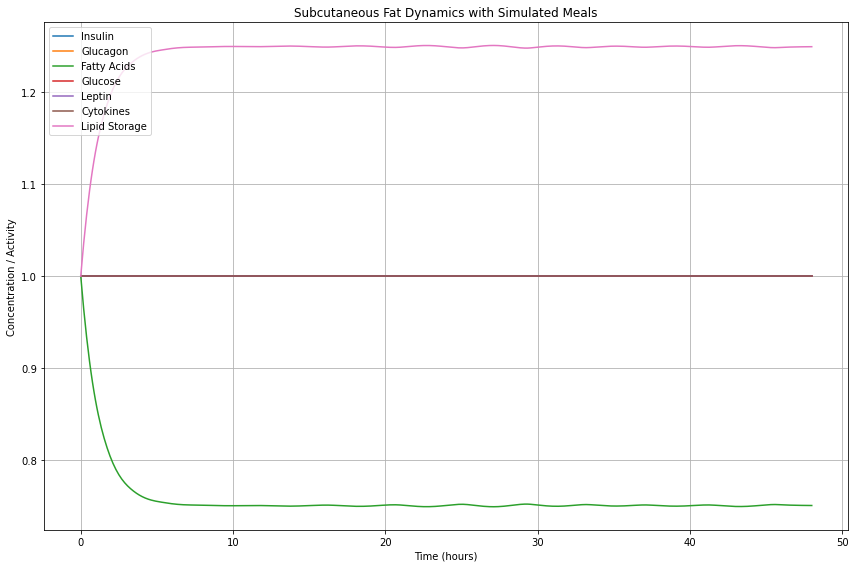

In [3]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from dataclasses import dataclass

n = 7  # number of variables

@dataclass
class Parameters:
    insulin_blood_adiposetissue: float
    insulin_adiposetissue_blood: float
    V_adiposetissue: float
    glucagon_blood_adiposetissue: float
    glucagon_adiposetissue_blood: float
    fattyacids_blood_adiposetissue: float
    fattyacids_adiposetissue_blood: float
    glucose_blood_adiposetissue: float
    glucose_adiposetissue_blood: float
    leptin_blood_adiposetissue: float
    leptin_adiposetissue_blood: float
    cytokines_blood_adiposetissue: float
    cytokines_adiposetissue_blood: float
    V_blood: float
    fa_to_triglyceride: float
    triglyceride_to_fa: float
    meal_times: list  # Added to control mealtimes

# Set parameters
p_adipose = Parameters(
    insulin_blood_adiposetissue=1,
    insulin_adiposetissue_blood=1,
    V_adiposetissue=1,
    glucagon_blood_adiposetissue=1,
    glucagon_adiposetissue_blood=1,
    fattyacids_blood_adiposetissue=1,
    fattyacids_adiposetissue_blood=1,
    glucose_blood_adiposetissue=1,
    glucose_adiposetissue_blood=1,
    leptin_blood_adiposetissue=1,
    leptin_adiposetissue_blood=1,
    cytokines_blood_adiposetissue=1.,
    cytokines_adiposetissue_blood=1,
    V_blood=1,
    fa_to_triglyceride=0.5,
    triglyceride_to_fa=0.3,
    meal_times=[8, 16, 32, 40]  # Meals every 8h (intermittent fasting)
)

# Meal input helper function
def meal_input(t, p):
    return 1.0 if any(abs(t - mt) < 0.5 for mt in p.meal_times) else 0.0

# ODE system
def adiposetissue(t, y, p):
    dydt = np.zeros(n)
    meal = meal_input(t, p)

    # Add insulin and glucose spikes at meals
    y = y.copy()
    y[0] += 0.1 * meal  # insulin spike
    y[3] += 0.2 * meal  # glucose spike

    dydt += insulin(t, y, p)
    dydt += glucagon(t, y, p)
    dydt += fattyacids(t, y, p)
    dydt += glucose(t, y, p)
    dydt += leptin(t, y, p)
    dydt += cytokines(t, y, p)
    dydt += lipidstorage(t, y, p)

    return dydt

# Sub-functions (unchanged)
def insulin(t, y, p):
    dydt = np.zeros(n)
    dydt[0] = (p.insulin_blood_adiposetissue * y[0] * p.V_blood - p.insulin_adiposetissue_blood * y[0] * p.V_adiposetissue) / p.V_adiposetissue
    return dydt

def glucagon(t, y, p):
    dydt = np.zeros(n)
    dydt[1] = (p.glucagon_blood_adiposetissue * y[1] * p.V_blood - p.glucagon_adiposetissue_blood * y[1] * p.V_adiposetissue) / p.V_adiposetissue
    return dydt

def fattyacids(t, y, p):
    dydt = np.zeros(n)
    dydt[2] = ((p.fattyacids_blood_adiposetissue * y[2] * p.V_blood - p.fattyacids_adiposetissue_blood * y[2] * p.V_adiposetissue) / p.V_adiposetissue
               - p.fa_to_triglyceride * y[2] + p.triglyceride_to_fa * y[6])
    return dydt

def glucose(t, y, p):
    dydt = np.zeros(n)
    dydt[3] = (p.glucose_blood_adiposetissue * y[3] * p.V_blood - p.glucose_adiposetissue_blood * y[3] * p.V_adiposetissue) / p.V_adiposetissue
    return dydt

def leptin(t, y, p):
    dydt = np.zeros(n)
    dydt[4] = (p.leptin_blood_adiposetissue * y[4] * p.V_blood - p.leptin_adiposetissue_blood * y[4] * p.V_adiposetissue) / p.V_adiposetissue
    return dydt

def cytokines(t, y, p):
    dydt = np.zeros(n)
    dydt[5] = (p.cytokines_blood_adiposetissue * y[5] * p.V_blood - p.cytokines_adiposetissue_blood * y[5] * p.V_adiposetissue) / p.V_adiposetissue
    return dydt

def lipidstorage(t, y, p):
    dydt = np.zeros(n)
    dydt[6] = p.fa_to_triglyceride * y[2] - p.triglyceride_to_fa * y[6]
    return dydt

# Initial state for all compartments
y0 = [1, 1, 1, 1, 1, 1, 1]

# Simulate over 48 hours
t_span = (0, 48)
t_eval = np.linspace(*t_span, 500)

# Solve the system
sol = solve_ivp(lambda t, y: adiposetissue(t, y, p_adipose), t_span, y0, t_eval=t_eval)

# Plotting
labels = ['Insulin', 'Glucagon', 'Fatty Acids', 'Glucose', 'Leptin', 'Cytokines', 'Lipid Storage']
plt.figure(figsize=(12, 8))
for i in range(n):
    plt.plot(sol.t, sol.y[i], label=labels[i])
plt.xlabel('Time (hours)')
plt.ylabel('Concentration / Activity')
plt.title('Subcutaneous Fat Dynamics with Simulated Meals')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Trying to build on my code, to refine a glucose metabolism path and oxidative phosphorylation pathway

Updates: Glycolysis: The breakdown of glucose into pyruvate is modeled, with part of the glucose being used for glycolysis.
Oxidative Phosphorylation: Pyruvate is used in the citric acid cycle, producing ATP. The ATP production rate (k_oxphos_rate) is added.
ATP dynamics: ATP production and consumption are tracked, with a basic consumption rate (dATP_dt = oxphos - 0.05 * ATP).

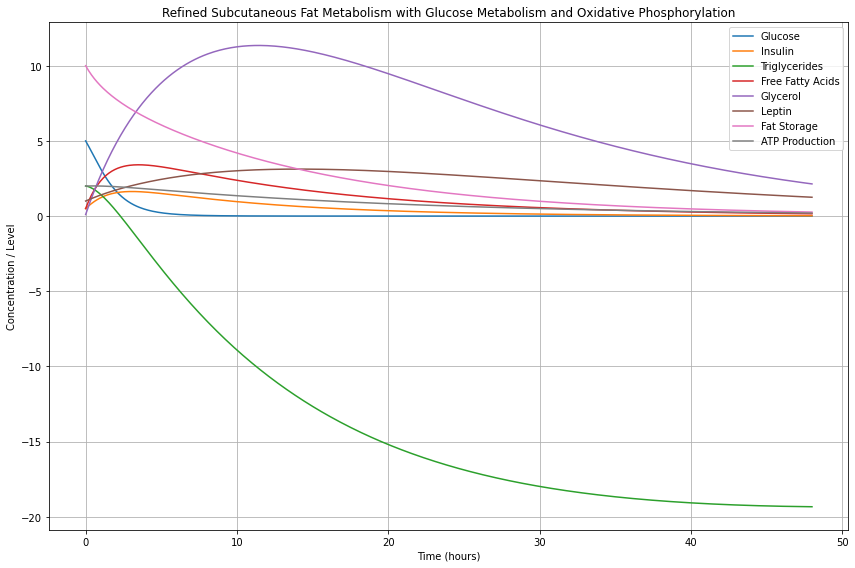

In [4]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Define the system of ODEs with glucose metabolism and oxidative phosphorylation
def fat_metabolism(y, t, params):
    G, I, TG, FFA, Glycerol, Leptin, Fat_Storage, ATP = y
    k_glucose_uptake, k_insulin_secretion, k_TG_input, k_lipogenesis, k_DNL, k_lipolysis, k_leptin_prod, k_FFA_use, k_glycerol_use, k_oxphos_rate = params

    # Glucose uptake by adipose (insulin-dependent)
    glucose_uptake = k_glucose_uptake * G * I

    # Glycolysis: Conversion of glucose to pyruvate (producing ATP)
    glycolysis = k_glucose_uptake * G * 0.2  # Assume 20% of glucose is used for glycolysis

    # Pyruvate to Acetyl-CoA for citric acid cycle
    pyruvate_to_acetylCoA = glycolysis * 0.8  # Assume 80% goes into the citric acid cycle

    # Citric acid cycle (CAC) - NADH and FADH2 production, driving ATP production through oxidative phosphorylation
    oxphos = k_oxphos_rate * pyruvate_to_acetylCoA  # Oxidative phosphorylation rate (ATP synthesis)

    # Insulin production (depends on glucose levels)
    insulin_secretion = k_insulin_secretion * G

    # Dietary TG input (assumed constant or meal-pulsed externally)
    TG_input = k_TG_input

    # Lipogenesis (storage of FFA into fat)
    lipogenesis = k_lipogenesis * FFA

    # De novo lipogenesis (from glucose to fat)
    DNL = k_DNL * G

    # Lipolysis (breakdown of stored fat)
    lipolysis = k_lipolysis * Fat_Storage

    # Leptin production proportional to fat storage
    leptin_prod = k_leptin_prod * Fat_Storage

    # FFA use by peripheral tissues
    FFA_use = k_FFA_use * FFA

    # Glycerol use by liver
    glycerol_use = k_glycerol_use * Glycerol

    # ODEs
    dG_dt = -glucose_uptake - DNL
    dI_dt = insulin_secretion - 0.1 * I
    dTG_dt = TG_input - lipogenesis
    dFFA_dt = lipolysis - lipogenesis - FFA_use
    dGlycerol_dt = lipolysis - glycerol_use
    dLeptin_dt = leptin_prod - 0.05 * Leptin
    dFat_Storage_dt = lipogenesis + DNL - lipolysis
    dATP_dt = oxphos - 0.05 * ATP  # ATP consumption rate (assuming some energy expenditure)

    return [dG_dt, dI_dt, dTG_dt, dFFA_dt, dGlycerol_dt, dLeptin_dt, dFat_Storage_dt, dATP_dt]

# Initial concentrations: [Glucose, Insulin, Triglycerides, FFA, Glycerol, Leptin, Fat_Storage, ATP]
y0 = [5.0, 0.5, 2.0, 0.5, 0.1, 1.0, 10.0, 2.0]  # Adding initial ATP (starting with 2 units)

# Parameters: tunable constants
params = [
    0.3,  # k_glucose_uptake
    0.2,  # k_insulin_secretion
    0.05, # k_TG_input
    0.4,  # k_lipogenesis
    0.2,  # k_DNL
    0.3,  # k_lipolysis
    0.05, # k_leptin_prod
    0.2,  # k_FFA_use
    0.1,  # k_glycerol_use
    0.5   # k_oxphos_rate (rate of ATP production via oxidative phosphorylation)
]

# Time points (e.g., 0 to 48 hours)
t = np.linspace(0, 48, 500)

# Solve ODEs
solution = odeint(fat_metabolism, y0, t, args=(params,))
G, I, TG, FFA, Glycerol, Leptin, Fat_Storage, ATP = solution.T

# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(t, G, label='Glucose')
plt.plot(t, I, label='Insulin')
plt.plot(t, TG, label='Triglycerides')
plt.plot(t, FFA, label='Free Fatty Acids')
plt.plot(t, Glycerol, label='Glycerol')
plt.plot(t, Leptin, label='Leptin')
plt.plot(t, Fat_Storage, label='Fat Storage')
plt.plot(t, ATP, label='ATP Production')  # Plotting ATP levels
plt.xlabel('Time (hours)')
plt.ylabel('Concentration / Level')
plt.title('Refined Subcutaneous Fat Metabolism with Glucose Metabolism and Oxidative Phosphorylation')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


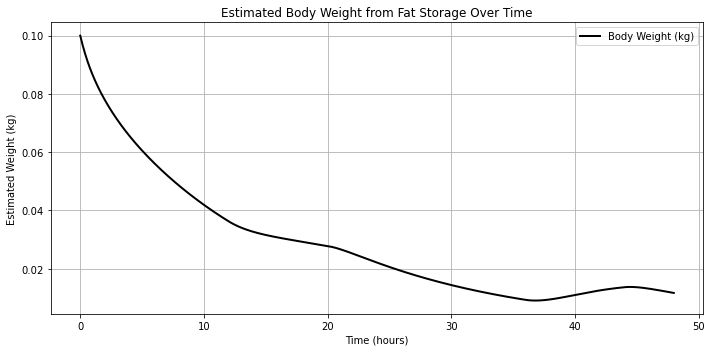

In [6]:
# Assume Fat_Storage is in arbitrary units (e.g., mmol), and convert to "weight"
fat_conversion_factor = 0.01  # e.g., 1 unit of Fat_Storage = 0.01 kg
Weight = Fat_Storage * fat_conversion_factor

# Plot weight over time
plt.figure(figsize=(10, 5))
plt.plot(t, Weight, label='Body Weight (kg)', color='black', linewidth=2)
plt.xlabel('Time (hours)')
plt.ylabel('Estimated Weight (kg)')
plt.title('Estimated Body Weight from Fat Storage Over Time')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
